In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sp # 'sympy' library for symbolic calculations

# Setting the fontsize of x, y label and title of python plots globally
import matplotlib as mpl
# Set global font sizes
mpl.rcParams['axes.titlesize'] = 12      # Title font size
mpl.rcParams['axes.labelsize'] = 12      # X and Y label font size
mpl.rcParams['xtick.labelsize'] = 12     # X tick label font size
mpl.rcParams['ytick.labelsize'] = 12     # Y tick label font size
mpl.rcParams['legend.fontsize'] = 12     # Legend font size
mpl.rcParams['font.size'] = 12           # General font size (e.g. for text)
mpl.rcParams['figure.dpi'] = 300         # higher dpi = more resolution

# For Interactive window (zoom-in, zoom-out feature)
# %matplotlib widget

# Uncomment the below one high quality plots
# plots and code are in same window
%matplotlib inline  
# for clear image, can be set to 'pdf/png' format also
%config InlineBackend.figure_format = 'retina'  

#### Universal constants in SI units ( Global variable )

In [82]:
G = 6.67 * (1e-11)
pc = 3*(1e16)
c = 3*(1e8)

# Mass of Sun in Kg
M_sun = 1e30

#### Binary Masses

In [83]:
# BINARY MASSES

# Primary Mass (bigger BH)
mass_1 = (1e3)*M_sun
# Secondary Mass (smaller BH)
mass_2 = 10*M_sun
# Total mass
total_mass = mass_1 + mass_2

eta = mass_1*mass_2/(total_mass**2)

# ISCO distance
r_min = (6*G*mass_1)/(c**2)

# Conversion factors ( Geometrized units G = c = 1 )
t0 = r_min/c        # from ISCO distance to seconds
l0 = r_min          # from ISCO distance to meters
m0 = (c**2)*r_min/G # from ISCO distance to kg

# Binary masses in ISCO distance (bcz we write DE in geometrized units ,i.e, G = c = 1)
m1 = mass_1 / m0
m2 = mass_2 / m0
M = total_mass / m0

#### Initial orbital parameters

In [84]:
# Initial eccentricity
e_i = 0.9 
# Initial value of semi-latus rectum in ISCO distance units
p_i = 100
# Initial value of omega in radians
omega_i = 0.0  
# Staring time
t_i = 0.0

# Final value of 'f' 
f_final = 1e15*(np.pi)

# Distance between binaries and observation point
R = 10 * 1e6 * pc / l0  # in meters

## Eccentric binaries in Vacuum

#### Averaged Osculating equations for GW backreaction 

$ \big< \frac{de}{df} \big>_{GW} = -\frac{8}{5} \eta \frac{(GM)^{5/2}}{c^5 p^{5/2}} \big( \frac{304}{24}e+\frac{121}{24} e^3 \big) $

$ \big< \frac{dp}{df} \big>_{GW} = -\frac{8}{5} \eta \frac{(GM)^{5/2}}{c^5 p^{3/2}} (8+7 e^2)  $

$ \big< \frac{d\omega}{df} \big>_{GW} = 0 $

$ \big< \frac{dt}{df} \big>_{GW} = \sqrt{\frac{p^3}{GM}} (1- e^2)^{-3/2} $ 

Set everything in Geometrized units $ \boxed{ G = c = 1 }$

In [85]:
# Averaged osculating equations considering only GW backreaction
def osculating_eqn_gw_brxn(f,y):
    e, p, omega, t = y
    dedf = -(8/5)*eta*(((M)**(5/2))/((p**(5/2))))*( (304/24)*e + (121/24)*(e**3) )
    dpdf = -(8/5)*eta*(((M)**(5/2))/((p**(3/2))))*( 8 + 7*(e**2) )
    domegadf = 0.0
    dtdf = np.sqrt((p**3)/(M)) * ((1- e**2)**(-3/2))
    return [dedf, dpdf, domegadf, dtdf]

class orbit_evolution_without_DM:
    # Initial parameters
    def __init__(self, e_i, p_i, omega_i, t_i, f_final):
        self.e_i = e_i
        self.p_i = p_i
        self.omega_i = omega_i
        self.t_i = t_i
        self.f_final = f_final
    
    # Orbit evolution considering only GW backreaction
    def orbit_evolution_gw_brxn(self):
        # Define the event function
        def stopping_condition(f, y):
            e, p, omega, t = y
            # Final value of semi-latus rectum in meters ( at ISCO )
            p_end = ( 6 + 2*self.e_i )*r_min/l0
            return p - p_end  # Integration stops when 'p' reaches ISCO distance

        # Make the event terminal and specify the direction
        stopping_condition.terminal = True    # ensures that the solver stops integration when the event is detected.
        stopping_condition.direction = 0      # allows the detection of zero crossings in any direction (i.e., both increasing and decreasing)

        # Coupled osculating equations
        def coupled_osculating_eqns(f,y):
            return osculating_eqn_gw_brxn(f,y)

        # Initial conditions
        initial_conditions = [self.e_i, self.p_i, self.omega_i, self.t_i]

        f_span = (0,self.f_final)   # True anomaly 'f'

        # Solve the system using solve_ivp
        solution = solve_ivp(coupled_osculating_eqns, f_span, initial_conditions, events=stopping_condition, method='RK45',
                            atol=1e-16, rtol=1e-10, max_step=100*np.pi) # One can set max_step=100*np.pi

        # print(solution.success)
        # print(solution.status)
        print(solution.message)
        
        return solution.t, solution.y

In [86]:
sol_GW = orbit_evolution_without_DM(e_i, p_i, omega_i, t_i, f_final)

fGW, yGW = sol_GW.orbit_evolution_gw_brxn() 

A termination event occurred.


In [87]:
#----FOR GW BACKREACTION ONLY
plt.figure(figsize=(28,7))

plt.subplot(141)
plt.plot( fGW, yGW[0])
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel('e', fontsize =14)
plt.yscale('log')
plt.title('GW backreaction ONLY :'+'\n' +rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.subplot(142)
plt.plot( fGW, yGW[1]/r_min)
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel('p ( ISCO units )', fontsize =14)
plt.yscale('log')
plt.title('GW backreaction ONLY :'+'\n' +rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.subplot(143)
plt.plot( fGW, yGW[2])
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel(r'$\omega$ ( radians )', fontsize =14)
plt.title('GW backreaction ONLY :'+'\n'+ rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

#---'e' Vs 'p'
plt.subplot(144)
plt.plot( yGW[1]/r_min , yGW[0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('p ( ISCO units )', fontsize =14)
plt.ylabel('e', fontsize =14)
plt.title('GW backreaction ONLY :'+'\n'+rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.show()

## Eccentric binaries in Static DM environment

#### Dark Matter density (NFW) parameters

<center>    
$ \rho_{DM} (r) = 
\begin{cases} 
 \frac{\rho_s}{(r/r_s)(1+ r/r_s)^2} &  r_{min} \leq r \leq r_{max} \\
0 &  r \leq r_{min} \\
\end{cases} $
</center>    

where, for given primary IMBH of mass $10^3 M_{\odot}$ and total mass of DM i.e, $M_{DM} = 10^6 M_{\odot}$,

$r_{s}= 23.1 pc$, $\rho_{s} = 5.61 M_{\odot} / pc^3$ and $r_{min} = r_{ISCO} = 3R_s = 6G m_1/c^2$

Above value gives $r_{max} = 150.659 pc$

In [8]:
# DARK-MATTER NFW Profile parameters

rho_s = 5.61*M_sun/((pc)**3) * (l0**3 / m0)
r_s = 23.1 * (pc) / l0
rmin = r_min/l0
r_max = 150.659 * pc / l0

I_v = 3    # Dynamical friction factor
lamda = 1  # Accretion factor

#### Averaged Osculating equations for (DF + Accretion) as perturbation 

## $ \big< \frac{de}{df} \big>_{DFacc} = - \frac{4 m_2  {r_{s}}^{3} (I_v + \lambda) \rho_{s} } {M^2} \mathcal{f} (e) $

## $ \big< \frac{dp}{df} \big>_{DFacc} = - \frac{4 m_2  {r_{s}}^{3} (I_v + \lambda) \rho_{s} } {M^2} \mathcal{g} (e) $

where,

## $ \mathcal{f} (e) = \int_{0}^{2\pi}  \frac{ p^2 [1+ e \cos (f)] [ e + \cos (f) ]}{ [1 + e^2 + 2 e \cos(f) ]^{3/2} [p + r_s + e r_s \cos(f) ]^2 } df $

## $ \mathcal{g} (e) = \int_{0}^{2\pi} \frac{ p^3 [1+ e \cos (f) ] }{ [1 + e^2 + 2 e \cos(f) ]^{3/2} [p + r_s + e r_s \cos(f) ]^2 } df $

$$ $$

## $ \big< \frac{d\omega}{df} \big>_{DFacc} = 0 $

## $ \big< \frac{dt}{df} \big>_{DFacc} = \sqrt{\frac{p^3}{GM}} (1-e^2)^{-3/2} $ 


#### Averaged Osculating equations for DM Minispike gravity as perturbation 

## $ \big< \frac{de}{df} \big>_{DM} = 0 $

## $ \big< \frac{dp}{df} \big>_{DM} = 0 $

## $ \big< \frac{d\omega}{df} \big>_{DM} = \frac{2 {r_s}^3  \rho_s }{M}  \int_{0}^{2\pi} \mathcal{h} (e, f)  df $

## $ \big< \frac{dt}{df} \big>_{DM} = \sqrt{\frac{p^3}{GM}} \Big[ (1-e^2)^{-3/2} + \frac{2 {r_s}^3  \rho_s }{M}  \int_{0}^{2\pi} \frac{\mathcal{h} (e, f)}{[1 + e \cos(f)]^2}  df \Big] $ 

Let

## $ \mathcal{h} (e, f) = \Big[ \frac{r_{min}}{(r_{min} + r_s)} - \frac{p}{[p + r_s + e r_s \cos(f)]} + \log \Big( \frac{[r_s + e r_s \cos(f) + p ]}{ [ 1 + e \cos(f) ][r_{min} + r_s ]} \Big) \Big] \frac{\cos(f)}{e}   $

Set everything in Geometrized units $ \boxed{ G = c = 1 }$

In [11]:
from scipy.integrate import simpson

# Averaged osculating equations considering only ( DF + Accretion )
def osculating_eqn_DF_accretion_NFW(y):
    e, p, omega, t = y
    
    x = np.linspace(0, 2*np.pi, 1000)
    fx = p**2 * (1 + e * np.cos(x)) * ( e + np.cos(x) )/( (1 + 2*e* np.cos(x) + e**2 )**(3/2) * (p + r_s + e*r_s*np.cos(x))**2 )
    f_e = simpson(fx, x)
    
    gx = p**3 * (1 + e * np.cos(x))/( (1 + 2*e* np.cos(x) + e**2 )**(3/2) * (p + r_s + e*r_s*np.cos(x))**2 )
    g_e = simpson(gx, x)
    
    dedf = -( 4*m2*(r_s**3)*( I_v + lamda )*rho_s/(M**2) )*f_e
    dpdf = -( 4*m2*(r_s**3)*( I_v + lamda )*rho_s/(M**2) )*g_e
    domegadf = 0.0
    dtdf = np.sqrt( (p**3)/M ) * (1 - e**2)**(-3/2)
    return [dedf, dpdf, domegadf, dtdf]

# Averaged osculating equations considering only DM gravity
def osculating_eqn_DM_gravity_NFW(y):
    e, p, omega, t = y
    
    x = np.linspace(0, 2*np.pi, 1000)
    hxe = ( rmin/(rmin + r_s) - p/(p + r_s + e*r_s*np.cos(x)) + np.log( (r_s+e*r_s*np.cos(x) + p)/((1+e*np.cos(x))*(rmin + r_s)) ) )*np.cos(x) / e
    
    dedf = 0.0
    dpdf = 0.0
    domegadf = (2* r_s**3 * rho_s/M) * simpson( hxe, x ) 
    dtdf = np.sqrt( (p**3)/M ) * ( (1 - e**2)**(-3/2) + (2* r_s**3 * rho_s/M) * simpson( hxe/((1 + e * np.cos(x))**2), x ) )
    return [dedf, dpdf, domegadf, dtdf]

class orbit_evolution_with_NFW_DM(orbit_evolution_without_DM):
    # Initial parameters
    def __init__(self, e_i, p_i, omega_i, t_i, f_final):
        super().__init__(e_i, p_i, omega_i, t_i, f_final)
        
    # Orbit evolution
    def orbit_evolution_NFW_DM_effect_gw_brxn(self, combination):
        # Define the event function
        def stopping_condition(f, y):
            e, p, omega, t = y
            # Final value of semi-latus rectum in meters ( at ISCO )
            p_end = ( 6 + 2*self.e_i )*r_min/l0
            return p - p_end  # Integration stops when 'p' reaches ISCO distance

        # Make the event terminal and specify the direction
        stopping_condition.terminal = True    # ensures that the solver stops integration when the event is detected.
        stopping_condition.direction = 0      # allows the detection of zero crossings in any direction (i.e., both increasing and decreasing)

        if combination==1:
            # Coupled osculating equations for ( DF + Accretion + GW brxn )
            def coupled_osculating_eqns(f, y):
                return np.add.reduce([osculating_eqn_gw_brxn(f, y), 
                                      osculating_eqn_DF_accretion_NFW(y)])

        if combination==2:
            # Coupled osculating equations for ( DM gravity + GW brxn )
            def coupled_osculating_eqns(f, y):
                return np.add.reduce([osculating_eqn_gw_brxn(f, y), 
                                      osculating_eqn_DM_gravity_NFW(y)])

        if combination==3:
            # Coupled osculating equations for NET effect ( DF + Accretion + DM gravity + GW brxn )
            def coupled_osculating_eqns(f, y):
                return np.add.reduce([osculating_eqn_gw_brxn(f, y), 
                                      osculating_eqn_DF_accretion_NFW(y), 
                                      osculating_eqn_DM_gravity_NFW(y)])
                
        # Initial conditions
        initial_conditions = [self.e_i, self.p_i, self.omega_i, self.t_i]

        f_span = (0,self.f_final)   # True anomaly 'f'

        # Solve the system using solve_ivp
        solution = solve_ivp(coupled_osculating_eqns, f_span, initial_conditions, events=stopping_condition, method='RK45', 
                             atol=1e-14, rtol=1e-10, max_step=100*np.pi) # One can set max_step=100*np.pi

        # print(solution.success)
        # print(solution.status)
        print(solution.message)
        
        return solution.t, solution.y

In [12]:
sol = orbit_evolution_with_NFW_DM(e_i, p_i, omega_i, t_i, f_final)

# # For ( DF + Accretion + GW brxn ) set combination = 1
# f_DFacc, y_DFacc = sol.orbit_evolution_NFW_DM_effect_gw_brxn(1)

# # For ( DM gravity + GW brxn ) set combination = 2
# f_DM, y_DM = sol.orbit_evolution_NFW_DM_effect_gw_brxn(2)

# For NET effect set combination = 3
f_NET, y_NET = sol.orbit_evolution_NFW_DM_effect_gw_brxn(3)

A termination event occurred.


In [ ]:
#----For ( DF + Accretion + GW BACKREACTION )
plt.figure(figsize=(28,7))

plt.subplot(141)
plt.plot( f_DFacc, y_DFacc[0])
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel('e', fontsize =14)
plt.yscale('log')
plt.title('DF + Accretion + GW brxn:'+'\n'+ rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.subplot(142)
plt.plot( f_DFacc, y_DFacc[1])
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel('p ( ISCO units )', fontsize =14)
plt.yscale('log')
plt.title('DF + Accretion + GW brxn:'+'\n'+ rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.subplot(143)
plt.plot( f_DFacc, y_DFacc[2])
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel(r'$\omega$ ( radians )', fontsize =14)
plt.title('DF + Accretion + GW brxn:'+'\n'+ rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

#----'e' Vs 'p'
plt.subplot(144)
plt.plot( y_DFacc[1], y_DFacc[0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('p ( ISCO units )', fontsize =14)
plt.ylabel('e', fontsize =14)
plt.title('DF + Accretion + GW brxn:'+'\n'+ rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.show()

In [ ]:
#----For ( DM gravity + GW BACKREACTION )
plt.figure(figsize=(28,7))

plt.subplot(141)
plt.plot( f_DM, y_DM[0])
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel('e', fontsize =14)
plt.yscale('log')
plt.title('DM gravity + GW brxn:'+'\n'+rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.subplot(142)
plt.plot( f_DM, y_DM[1])
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel('p ( ISCO units )', fontsize =14)
plt.yscale('log')
plt.title('DM gravity + GW brxn:'+'\n'+rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.subplot(143)
plt.plot( f_DM, y_DM[2])
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel(r'$\omega$ ( radians )', fontsize =14)
plt.title('DM gravity + GW brxn:'+'\n'+rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

#---'e' Vs 'p'
plt.subplot(144)
plt.plot( y_DM[1], y_DM[0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('p ( ISCO units )', fontsize =14)
plt.ylabel('e', fontsize =14)
plt.title('DM gravity + GW brxn:'+'\n'+rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.show()

In [13]:
#----For NET effect
plt.figure(figsize=(28,7))

plt.subplot(141)
plt.plot( f_NET, y_NET[0])
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel('e', fontsize =14)
plt.yscale('log')
plt.title('NET effect:'+'\n'+rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.subplot(142)
plt.plot( f_NET, y_NET[1])
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel('p ( ISCO units )', fontsize =14)
plt.yscale('log')
plt.title('NET effect:'+'\n'+rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.subplot(143)
plt.plot( f_NET, y_NET[2])
plt.xlabel('f ( radians )', fontsize =14)
plt.ylabel(r'$\omega$ ( radians )', fontsize =14)
plt.title('NET effect:'+'\n'+rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

#----'e' Vs 'p'
plt.subplot(144)
plt.plot( y_NET[1], y_NET[0])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('p ( ISCO units )', fontsize =14)
plt.ylabel('e', fontsize =14)
plt.title('NET effect:'+'\n'+rf'$e_i$ = {e_i}, $p_i$ = {p_i}(ISCO units), $\omega_i$ = {omega_i}')

plt.show()

## Eccentric: Nonlinear GW memory

#### Perturbed kepler equation of motion 

The perurbed Newtonian binary we are setting up is (or say perturbed Kepler e.o.m ) -

$ \ddot{r} = r \dot{\phi}^2 - G \frac{m}{r^2} - G \frac{M_{DM}}{r^{2}} - G^2 \frac{4\pi m_2 \rho_{DM} (I_v + \lambda) \dot{r}}{v^3} $

$ \ddot{\phi} = - \frac{2 \dot{r} \dot{\phi}}{r} - G^2 \frac{4\pi m_2 \rho_{DM} (I_v + \lambda) \dot{\phi}}{v^3} $

where,

$ M_{DM} (r) = 4 \pi  \rho_s {r_s}^3 \left[ -\frac{r}{r+r_s}+\log (r+r_s)+\frac{r_{min}}{r_{min}+r_s}-\log (r_{min}+r_s) \right] $

And, 

$ \dot{r} = \sqrt{\frac{Gm}{p}} e \sin{f} $

$ \dot{f} = \dot{\phi} = \sqrt{\frac{Gm}{p^3}}(1 + e \cos{f} )^2 $

$ v = \sqrt{ {\dot{r}}^2 + r^2 {\dot{\phi}}^2}$

And,

$  m = M = m_1 + m_2 $

Set everything in Geometrized units $ \boxed{ G = c = 1 }$

In [70]:
# SYMBOLIC CALCULATIONS

# Declare constants
m_, eta_, rmin_, m2_, rho_s_, r_s_, Iv_, lamda_ = sp.symbols('m eta rmin m2 rho_s r_s Iv lamda')

# Declare independent variable time as symbol
t_ = sp.symbols('t')

# Declare time-dependent functions
r_ = sp.Function('r')(t_)
phi_ = sp.Function('phi')(t_)
drdt_ = sp.Function('drdt')(t_) 
dphidt_ = sp.Function('dphidt')(t_)

# Declare time derivatives of 'r' and 'phi' as symbols 
r_dot_, r_dotdot_, r_dotdotdot_, phi_dot_, phi_dotdot_, phi_dotdotdot_ = sp.symbols('r_dot, r_dotdot, r_dotdotdot, phi_dot, phi_dotdot, phi_dotdotdot')

# Define expressions for velocity 'v'
v_ = sp.sqrt( drdt_**2 + (r_**2) * (dphidt_**2) )

# Define expression for DM NFW density
rho_dm_ = rho_s_ / ( (r_/r_s_) * (1+ (r_/r_s_) )**2  )

# Define expression for DM NFW mass as function of 'r'
Mdm_ = sp.integrate(4* sp.pi * r_**2 * rho_dm_, (r_, rmin_, r_))
 
# Eccentric : Perturbed Newtonian binary e.o.m
d2rdt2_ = (r_*(dphidt_**2)) - (m_/(r_**2)) - Mdm_/(r_**2) - (4*sp.pi*m2_*rho_dm_*(Iv_+lamda_)*drdt_/(v_**3))
d2phidt2_ = -((2*drdt_*dphidt_)/r_) - (4*sp.pi*m2_*rho_dm_*(Iv_+lamda_)*dphidt_/(v_**3))

# 3rd-time derivative of 'r' and 'phi'
d3rdt3_ = sp.simplify(sp.diff(d2rdt2_, t_))
d3phidt3_ = sp.simplify(sp.diff(d2phidt2_, t_))

# Substitute 'r' and 'phi' time derivatives as symbols
d3rdt3 = d3rdt3_.subs({
    sp.Derivative(r_, t_): r_dot_,
    drdt_ : r_dot_,
    sp.Derivative(drdt_, t_): r_dotdot_,
    sp.Derivative(phi_, t_): phi_dot_,
    dphidt_ : phi_dot_,
    sp.Derivative(dphidt_, t_): phi_dotdot_})

d3phidt3 = d3phidt3_.subs({
    sp.Derivative(r_, t_): r_dot_,
    drdt_ : r_dot_,
    sp.Derivative(drdt_, t_): r_dotdot_,
    sp.Derivative(phi_, t_): phi_dot_,
    dphidt_ : phi_dot_,
    sp.Derivative(dphidt_, t_): phi_dotdot_})

# Print to check derivatives were done correctly
# print(f'd3rdt3 = {sp.simplify(d3rdt3)}') 
# print(f'd3phidt3 = {sp.simplify(d3phidt3)}')
 
# Create numerical function of 3rd-time derivative of 'r' and 'phi'
r_dotdotdot_func = sp.lambdify((r_, r_dot_, r_dotdot_, phi_dot_, phi_dotdot_,
                                m_, rmin_, m2_, rho_s_, r_s_, Iv_, lamda_), d3rdt3, modules='numpy')
phi_dotdotdot_func = sp.lambdify((r_, r_dot_, r_dotdot_, phi_dot_, phi_dotdot_,
                                  m_, rmin_, m2_, rho_s_, r_s_, Iv_, lamda_), d3phidt3, modules='numpy')

i = 1j # complex number

# Define the expression for Mass-quadrupole moments
I20_ = -4 * sp.sqrt(sp.pi / 15) * eta_ * m_ * r_**2
I22P_ = 2 * sp.sqrt(2*sp.pi/5) * eta_ * m_ * r_**2 * sp.exp(-2*i*phi_)
I22M_ = 2 * sp.sqrt(2*sp.pi/5) * eta_ * m_ * r_**2 * sp.exp( 2*i*phi_)

# 3rd-time derivative of Mass-qudrupole moments
I20ddd_  = sp.simplify(sp.diff(I20_, t_, 3))
I22Pddd_ = sp.simplify(sp.diff(I22P_, t_, 3))
I22Mddd_ = sp.simplify(sp.diff(I22M_, t_, 3))

# Substitute 'r' and 'phi' time derivatives as symbols
I20ddd = I20ddd_.subs({
    sp.Derivative(r_, t_): r_dot_,
    sp.Derivative(r_, t_, 2): r_dotdot_,
    sp.Derivative(r_, t_, 3): r_dotdotdot_,
    sp.Derivative(phi_, t_): phi_dot_,
    sp.Derivative(phi_, t_, 2): phi_dotdot_,
    sp.Derivative(phi_, t_, 3): phi_dotdotdot_})

I22Pddd = I22Pddd_.subs({
    sp.Derivative(r_, t_): r_dot_,
    sp.Derivative(r_, t_, 2): r_dotdot_,
    sp.Derivative(r_, t_, 3): r_dotdotdot_,
    sp.Derivative(phi_, t_): phi_dot_,
    sp.Derivative(phi_, t_, 2): phi_dotdot_,
    sp.Derivative(phi_, t_, 3): phi_dotdotdot_})

I22Mddd = I22Mddd_.subs({
    sp.Derivative(r_, t_): r_dot_,
    sp.Derivative(r_, t_, 2): r_dotdot_,
    sp.Derivative(r_, t_, 3): r_dotdotdot_,
    sp.Derivative(phi_, t_): phi_dot_,
    sp.Derivative(phi_, t_, 2): phi_dotdot_,
    sp.Derivative(phi_, t_, 3): phi_dotdotdot_})

# Print to check derivatives were done correctly
# print(f'I20ddd = {sp.simplify(I20ddd)}') 
# print(f'I22Pddd = {sp.simplify(I22Pddd)}') 
# print(f'I22Mddd = {sp.simplify(I22Mddd)}') 

# Create numerical function of 3rd-time derivative of quadrupole moments
I20ddd_func  = sp.lambdify((r_, phi_, r_dot_, r_dotdot_, r_dotdotdot_, phi_dot_, phi_dotdot_, phi_dotdotdot_, m_, eta_), 
                           I20ddd, modules='numpy')
I22Pddd_func = sp.lambdify((r_, phi_, r_dot_, r_dotdot_, r_dotdotdot_, phi_dot_, phi_dotdot_, phi_dotdotdot_, m_, eta_), 
                           I22Pddd, modules='numpy')
I22Mddd_func = sp.lambdify((r_, phi_, r_dot_, r_dotdot_, r_dotdotdot_, phi_dot_, phi_dotdot_, phi_dotdotdot_, m_, eta_), 
                           I22Mddd, modules='numpy')

In [75]:
# Relative distance between binaries
def rel_distance(y, f):
    e, p, omega, t = y
    return p/( 1 + e*np.cos(f) )

def r_dot(y, f):
    e, p, omega, t = y
    return np.sqrt(M/p) * e * np.sin(f)

def phi_dot(y, f):
    e, p, omega, t = y
    return np.sqrt( M/(p**3) ) * ( 1 + e * np.cos(f) )**2 

# Define function for relative velocity
def v(y, f):
    return np.sqrt( (r_dot(y, f))**2 + ( rel_distance(y, f) * phi_dot(y, f) )**2 )

# Define function for DM NFW density
def rho_dm_NFW(y, f):
    r = rel_distance(y, f)
    return rho_s/( (r/r_s)*( ( 1 +  (r/r_s) )**2 ) )

def Mdm_NFW(y, f):
    r = rel_distance(y, f)
    return 4 * np.pi * r_s**3 * rho_s * (  rmin/(rmin+r_s) - r/(r+r_s) + np.log((r+r_s)/(rmin+r_s)) )

# Eccentric : Perturbed Newtonian binary 
def r_dotdot(y, f, combination): # Radial e.o.m
    r = rel_distance(y, f)
    rdot = r_dot(y, f)
    phidot = phi_dot(y, f)
    velocity = v(y, f)
    if combination==0:
        Mdm = 0.0
        rhodm = 0.0
    else:
        Mdm = Mdm_NFW(y, f)
        rhodm = rho_dm_NFW(y, f)
    return r * phidot**2 - (M)/(r**2) - (Mdm)/(r**2) - 4 * np.pi * m2 * rhodm * (I_v+lamda) * rdot/velocity**3
    
def phi_dotdot(y, f, combination): # Azimuthal angle e.o.m
    r = rel_distance(y, f)
    rdot = r_dot(y, f)
    phidot = phi_dot(y, f)
    velocity = v(y, f)
    if combination==0:
        rhodm = 0.0
    else:
        rhodm = rho_dm_NFW(y, f)
    return -2*rdot*phidot/r - 4 * np.pi * m2 * rhodm * (I_v+lamda) * phidot/velocity**3

def dh20dt_mem(y, f, R, combination):
    r = rel_distance(y, f)
    rdot = r_dot(y, f)
    rdotdot = r_dotdot(y, f, combination)
    phidot = phi_dot(y, f)
    phidotdot = phi_dotdot(y, f, combination)
    
    if combination==0: # Switch OFF all DM environment effects i.e we observe just GW backrxn effect
        rhos = 0.0
    else: # Switch ON all DM environment effects + GW backrxn
        rhos = rho_s

    rdotdotdot = r_dotdotdot_func(r, rdot, rdotdot, phidot, phidotdot, M, rmin, m2, rhos, r_s, I_v, lamda)
    phidotdotdot = phi_dotdotdot_func(r, rdot, rdotdot, phidot, phidotdot, M, rmin, m2, rhos, r_s, I_v, lamda)

    h20dotN =  I20ddd_func(r, f, rdot, rdotdot, rdotdotdot, phidot, phidotdot, phidotdotdot, M, eta )/(R * np.sqrt(2))
    h22PdotN = I22Pddd_func(r, f, rdot, rdotdot, rdotdotdot, phidot, phidotdot, phidotdotdot, M, eta)/(R * np.sqrt(2))
    h22MdotN = I22Mddd_func(r, f, rdot, rdotdot, rdotdotdot, phidot, phidotdot, phidotdotdot, M, eta)/(R * np.sqrt(2))
    h22dotN = (np.abs( h22PdotN * h22MdotN ))**(1/2)

    return (R/42)*(np.sqrt(15/(2*np.pi)))*( 2 * (h22dotN**2) - (h20dotN**2) )
    

def dh40dt_mem(y, f, R, combination):
    r = rel_distance(y, f)
    rdot = r_dot(y, f)
    rdotdot = r_dotdot(y, f, combination)
    phidot = phi_dot(y, f)
    phidotdot = phi_dotdot(y, f, combination)
    
    if combination==0: # Switch OFF all DM environment effects i.e we observe just GW backrxn effect
        rhos = 0.0
    else: # Switch ON all DM environment effects + GW backrxn
        rhos = rho_s

    rdotdotdot = r_dotdotdot_func(r, rdot, rdotdot, phidot, phidotdot, M, rmin, m2, rhos, r_s, I_v, lamda)
    phidotdotdot = phi_dotdotdot_func(r, rdot, rdotdot, phidot, phidotdot, M, rmin, m2, rhos, r_s, I_v, lamda)

    h20dotN =  I20ddd_func(r, f, rdot, rdotdot, rdotdotdot, phidot, phidotdot, phidotdotdot, M, eta )/(R * np.sqrt(2))
    h22PdotN = I22Pddd_func(r, f, rdot, rdotdot, rdotdotdot, phidot, phidotdot, phidotdotdot, M, eta)/(R * np.sqrt(2))
    h22MdotN = I22Mddd_func(r, f, rdot, rdotdot, rdotdotdot, phidot, phidotdot, phidotdotdot, M, eta)/(R * np.sqrt(2))
    h22dotN = (np.abs( h22PdotN * h22MdotN ))**(1/2)

    return (R/1260)*(np.sqrt(5/(2*np.pi)))*( (h22dotN**2) + 3 * (h20dotN**2) )

# Averaging h20 mode of nonlinear memory over one time period
def integrand_h20(y, f, R, combination):
    e, p, omega, t = y
    func_f = dh20dt_mem(y, f, R, combination)
    return func_f/( 1 + e * np.cos(f) )**2

# Averaging h40 mode of nonlinear memory over one time period
def integrand_h40(y, f, R, combination):
    e, p, omega, t = y
    func_f = dh40dt_mem(y, f, R, combination)
    return func_f/( 1 + e * np.cos(f) )**2 

# Calculating hl0 (l = 2, 4) mode of Nonlinear memory
class calculate_nonlinear_memory_NFW(orbit_evolution_with_NFW_DM):
    # Initial parameters
    def __init__(self, e_i, p_i, omega_i, t_i, f_final, R):
        super().__init__(e_i, p_i, omega_i, t_i, f_final)
        self.R = R
        
    def cal_hl0(self, combination): 
        sol_without_DM = orbit_evolution_without_DM(self.e_i, self.p_i, self.omega_i, self.t_i, self.f_final)
        sol_with_DM = orbit_evolution_with_NFW_DM(self.e_i, self.p_i, self.omega_i, self.t_i, self.f_final)
        
        if combination==0: # GW backrxn only ( FAVATA result )
            f, y = sol_without_DM.orbit_evolution_gw_brxn()
        else: # NET : DF + Accretion + DM gravity + GW backrxn
            f, y = sol_with_DM.orbit_evolution_NFW_DM_effect_gw_brxn(3)

        e, p, omega, t = y
        num = len(e)

        # Calculating average dh20dt_mem and dh40dt_mem wrt true anomaly 
        avg_dh20dt_mem = []
        avg_dh40dt_mem = []

        for i in range(num):
            fdash = np.linspace(0,2*np.pi,1000) 
            # For h20 mode
            g_e1 = integrand_h20(y[:,i], fdash, self.R, combination)
            avg_dh20dt_mem.append( ( ((1 - (e[i])**2 )**(3/2)) / (2*np.pi) ) * simpson(g_e1, fdash)) # Integrating using Simpson's rule
            # For h40 mode
            g_e2 = integrand_h40(y[:,i], fdash, self.R, combination)
            avg_dh40dt_mem.append( ( ((1 - (e[i])**2 )**(3/2)) / (2*np.pi) ) * simpson(g_e2, fdash)) # Integrating using Simpson's rule

        avg_dh20dt_mem = np.array(avg_dh20dt_mem)
        avg_dh40dt_mem = np.array(avg_dh40dt_mem)

        avg_dh20de_mem = []
        avg_dh40de_mem = []

        for i in range(num):
            if combination==0: # GW backrxn only ( FAVATA result )
                dedf, dpdf, domegadf, dtdf = osculating_eqn_gw_brxn(f[i], y[:,i])
                avg_dh20de_mem.append( avg_dh20dt_mem[i] * dtdf / dedf ) 
                avg_dh40de_mem.append( avg_dh40dt_mem[i] * dtdf / dedf ) 
            else: # NET : DF + Accretion + DM gravity + GW backrxn
                dedf, dpdf, domegadf, dtdf = np.add.reduce([osculating_eqn_gw_brxn(f[i],y[:,i]),
                                               osculating_eqn_DF_accretion_NFW(y[:,i]),
                                               osculating_eqn_DM_gravity_NFW(y[:,i])])
                avg_dh20de_mem.append( avg_dh20dt_mem[i] * dtdf / dedf )
                avg_dh40de_mem.append( avg_dh40dt_mem[i] * dtdf / dedf )

        # Calculating h20_mem and h40_mem as function of eccentricity using Euler's method
        h20_mem = np.zeros((np.shape(e))) 
        h40_mem = np.zeros((np.shape(e))) 

        for j in range(num-1):
            # Euler method
            h20_mem[j+1] = h20_mem[j] + avg_dh20de_mem[j] * ( e[j+1] - e[j] ) 
            h40_mem[j+1] = h40_mem[j] + avg_dh40de_mem[j] * ( e[j+1] - e[j] ) 

        return f, y, h20_mem, h40_mem

In [76]:
# Calculating Nonlinear GW memory for given initial orbital parameters
nonlinear_memory = calculate_nonlinear_memory_NFW(e_i, p_i, omega_i, t_i, f_final, R)

# Only GW backreaction ( FAVATA result )
fgw, ygw, h20_mem_gw, h40_mem_gw = nonlinear_memory.cal_hl0(combination=0)

print('h20_mem_gw = ',h20_mem_gw[-1])
print('h40_mem_gw = ',h40_mem_gw[-1])

# NET : DM gravity + DF + Accretion + GW brxn
f_net, y_net, h20_mem_NET, h40_mem_NET = nonlinear_memory.cal_hl0(combination=3)

print('h20_mem_NET = ',h20_mem_NET[-1])
print('h40_mem_NET = ',h40_mem_NET[-1])

A termination event occurred.
h20_mem_gw =  9.597172279929323e-22
h40_mem_gw =  9.255155231492091e-24
A termination event occurred.
h20_mem_NET =  2.882028794997111e-21
h40_mem_NET =  2.779314988243217e-23


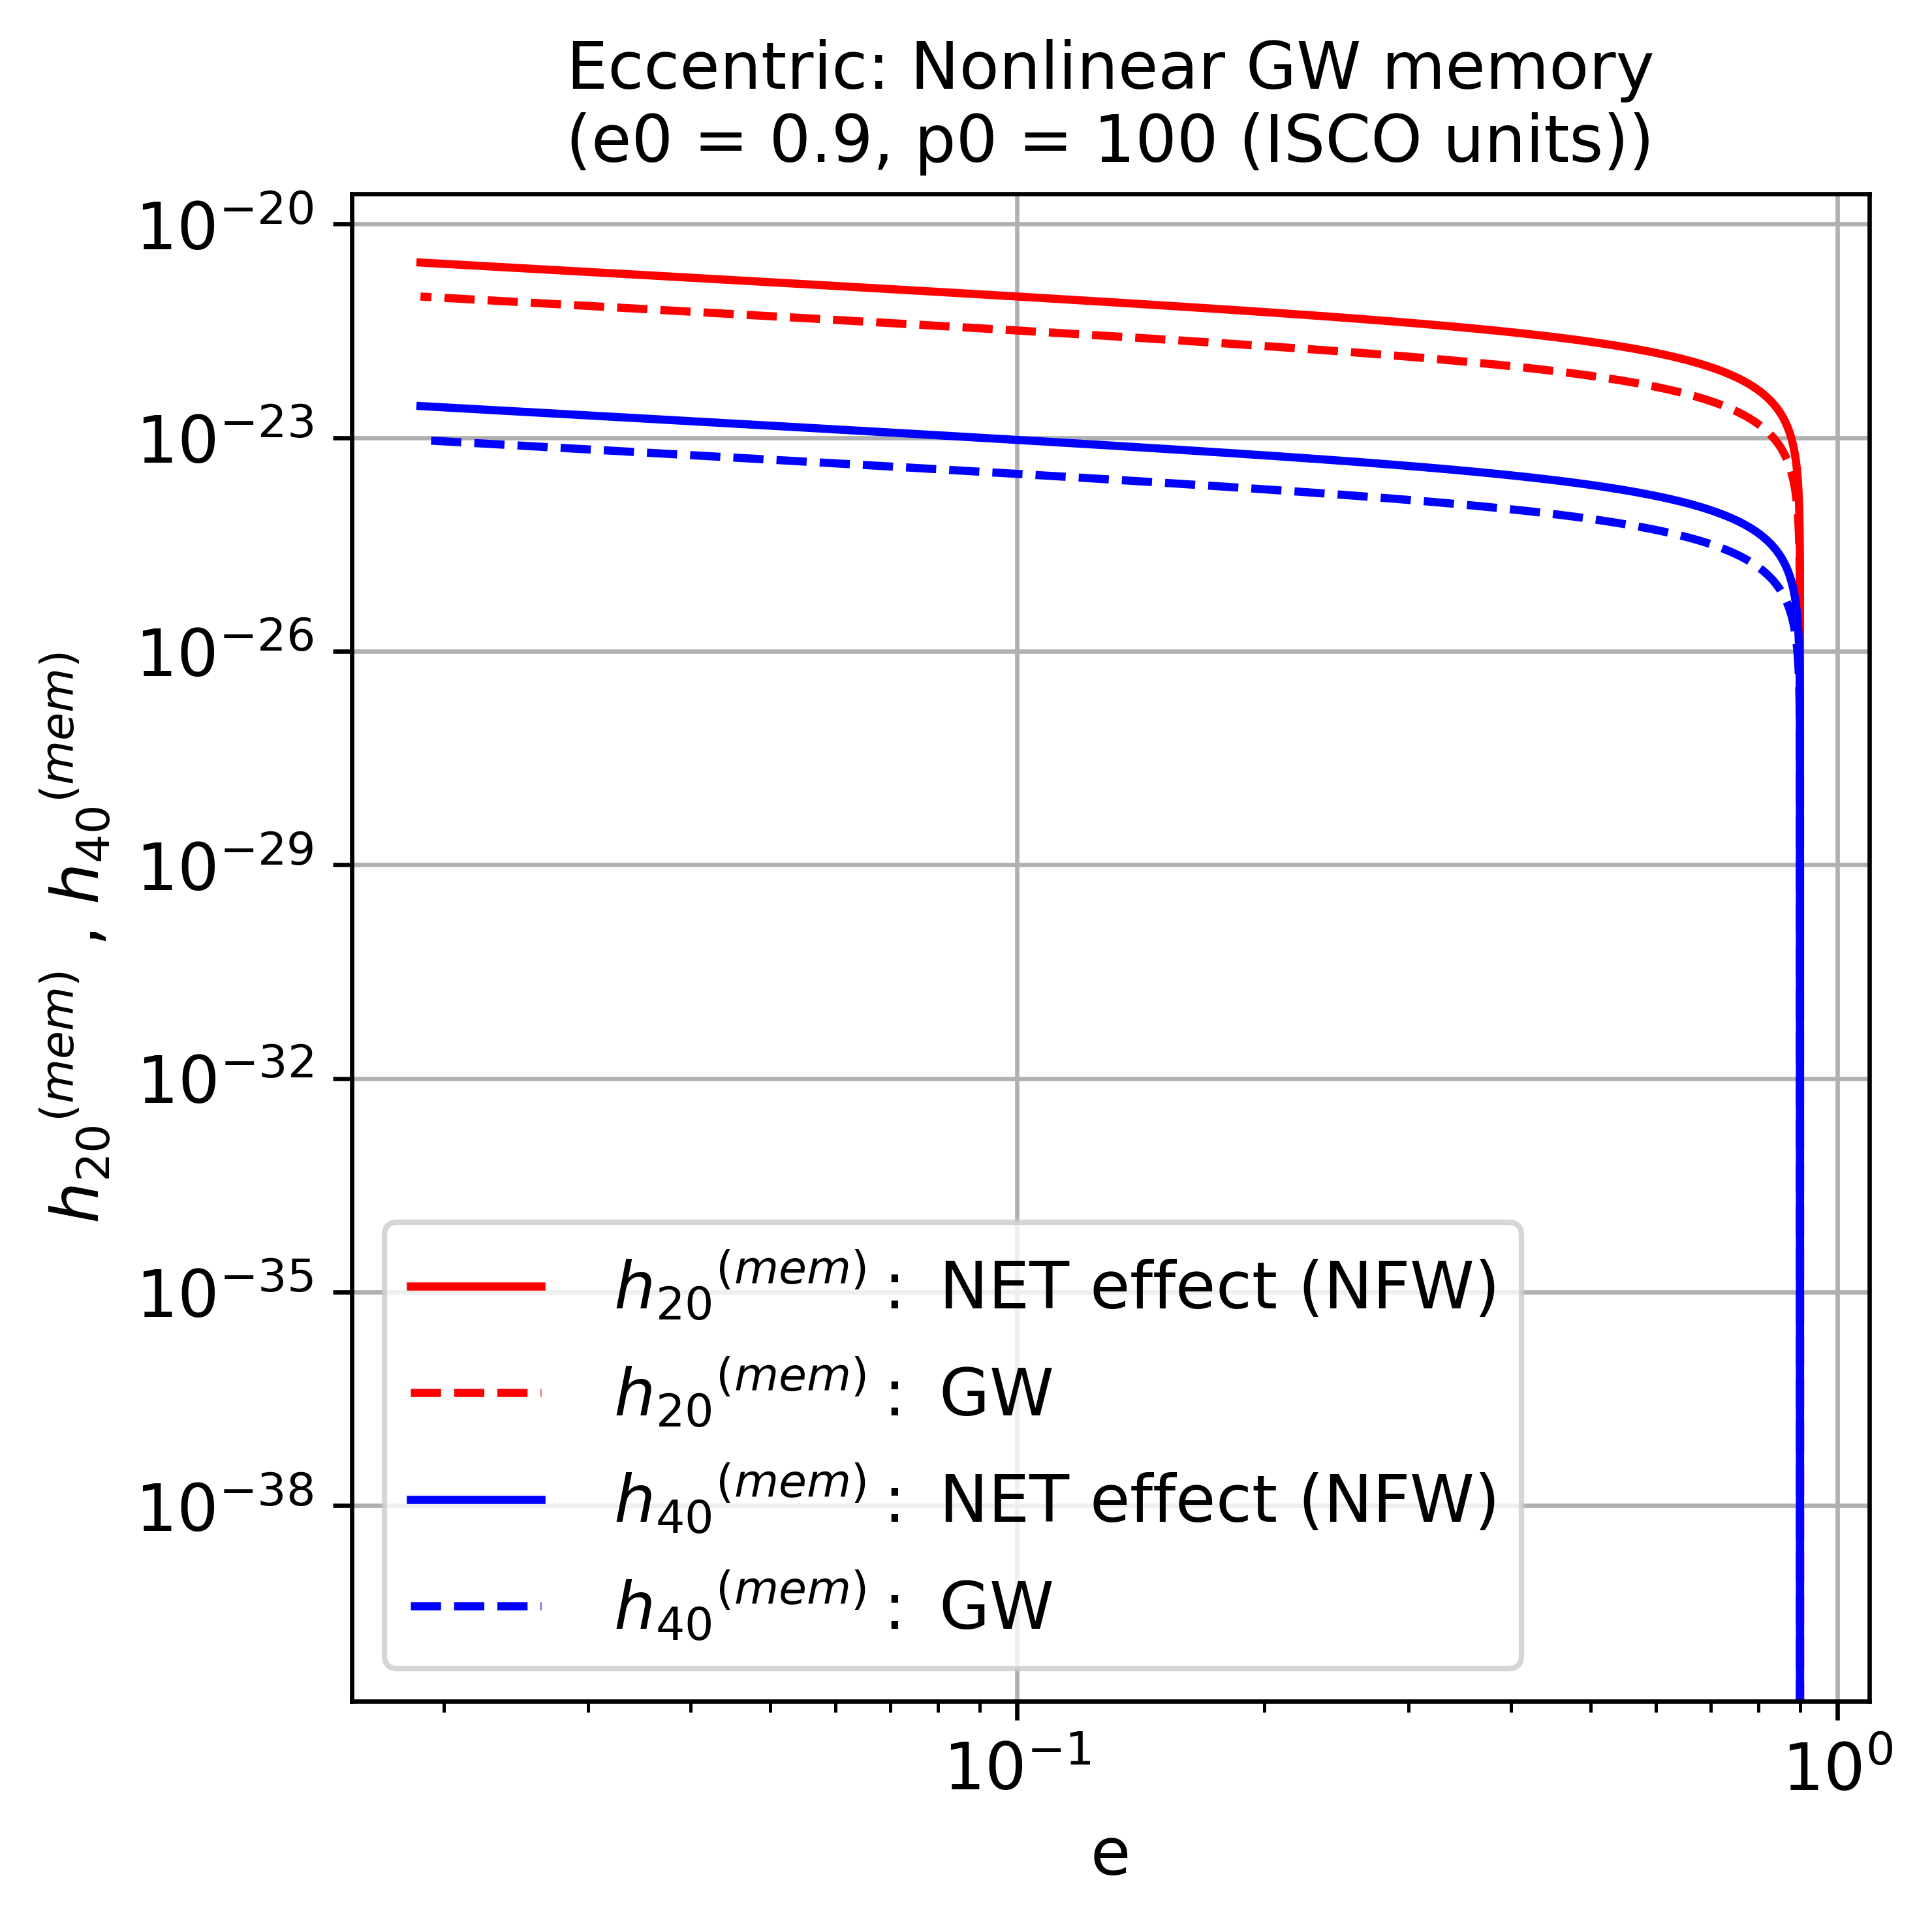

In [77]:
# Plotting
plt.figure(figsize=(5,5))
plt.title('Eccentric: Nonlinear GW memory' + "\n" + f'(e0 = {e_i}, p0 = {p_i} (ISCO units))')

plt.plot( y_net[0,:], h20_mem_NET, label = r' ${h_{20}}^{(mem)}:$' +' NET effect (NFW)', linestyle='-', color='red' )
plt.plot( ygw[0,:], h20_mem_gw, label= r' ${h_{20}}^{(mem)}: $' + ' GW', linestyle='--', color='red')

plt.plot( y_net[0,:], h40_mem_NET, label = r' ${h_{40}}^{(mem)}:$' + ' NET effect (NFW)', linestyle='-', color='blue' )
plt.plot( ygw[0,:], h40_mem_gw, label= r' ${h_{40}}^{(mem)}:$' + ' GW', linestyle='--', color='blue')

plt.xlabel('e')
plt.ylabel(r' ${h_{20}}^{(mem)}$ , ${h_{40}}^{(mem)}$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

#### Nonlinear memory GW strain $h^{(mem)}(f)$  Vs frequency

$ h^{(mem)}(f) = \sqrt{ |h_{+}^{(mem)}(f)|^2 + |h_{\times}^{(mem)}(f)|^2 } $

##### Nonlinear memory GW polarisation

The polarisation for the non-linear memory waves for bound **eccentric orbits** computed by summing the $m =0$ modes -

$ {h_{+}}^{(mem)} ( e, \theta ) = \frac{1}{8} \sqrt{\frac{30}{\pi}} {\sin}^2{\theta} \Big[ {h_{20}}^{(mem)} + \frac{\sqrt{3}}{2} {h_{40}}^{(mem)}(7 {\cos}^2{\theta} -1)  \Big]$

$ {h_{\times}}^{(mem)} ( e, \theta ) = 0 $

Let $\theta = \frac{\pi}{3} $

In [78]:
# Plus polarisation of GW nonlinear memory
def hplus_mem(h20mem,h40mem,theta):
        return (1/8)*np.sqrt(30/np.pi) * ((np.sin(theta))**2)*( h20mem + np.sqrt(3/4) * h40mem*( 7*((np.cos(theta))**2) -1 ) )

# Noise spectral density of LISA
def LISA_noise_psd(f_without_DM, f_with_DM):
    if len(f_without_DM) >= len(f_with_DM):
        frq = f_without_DM
    else:
        frq = f_with_DM
    
    Sh_inst = 9.18e-52 * frq**(-4) + 1.59e-41 + 9.18e-38 * (frq**2)
    Sh_gal = 2.1e-45 * (frq**(-7/3))
    Sh_exgal = 4.2e-47 * (frq**(-7/3))
    mission = 1.5/(3600*24*365) # taken 1.5 per year
    dNdf = 2e-3 * (frq**(-11/3))
    
    deno = np.exp(-mission*dNdf)
    # Get the smallest positive number that can be differentiated from zero
    epsilon = 1e-16
    if np.any(deno==0):
        deno[ deno == 0 ] = epsilon
    
    return frq, np.sqrt(np.minimum(( Sh_inst/deno ) + Sh_exgal, Sh_inst + Sh_gal + Sh_exgal))

# Noise spectral density of GWSat
def GWSat_noise_psd(f_without_DM, f_with_DM):
    if len(f_without_DM) >= len(f_with_DM):
        frq = f_without_DM
    else:
        frq = f_with_DM
    return frq, np.sqrt( ( 1e-25 * frq**(-2) + 1e-23 + 1e-24 * frq**(-1))**2 )

# Nonlinear memory GW polarisation FFT
def nonlinear_memory_gw_pol_fft(h20mem, h40mem):
    theta = np.pi/3
    # Nonlinear memory GW polarisation time signal 
    hplus_t_mem = hplus_mem(h20mem,h40mem,theta)
    # Fourier transform
    hplus_f_mem = np.fft.fft(hplus_t_mem) 
    freq = np.fft.fftfreq(len(hplus_f_mem))
    # selecting only positive frequencies
    l = len(freq[freq>0]) 
    # Nonlinear memory GW polarisation frequency signal 
    hp_f_mem = np.abs(hplus_f_mem[1:l])
    pos_freq = freq[1:l]
    return hp_f_mem, pos_freq

In [79]:
# Load the Strain sensitivity of various GW detectors
CE_data = np.loadtxt('cosmic_explorer_40km_lf_strain.txt')         # Cosmic explorer data
ET_data = np.loadtxt('ET-0002A-18_ETBSensitivityCurveTxtFile.txt') # Einstein telescope low frequency data
aLIGO_data = np.loadtxt('aLIGODesign.txt')

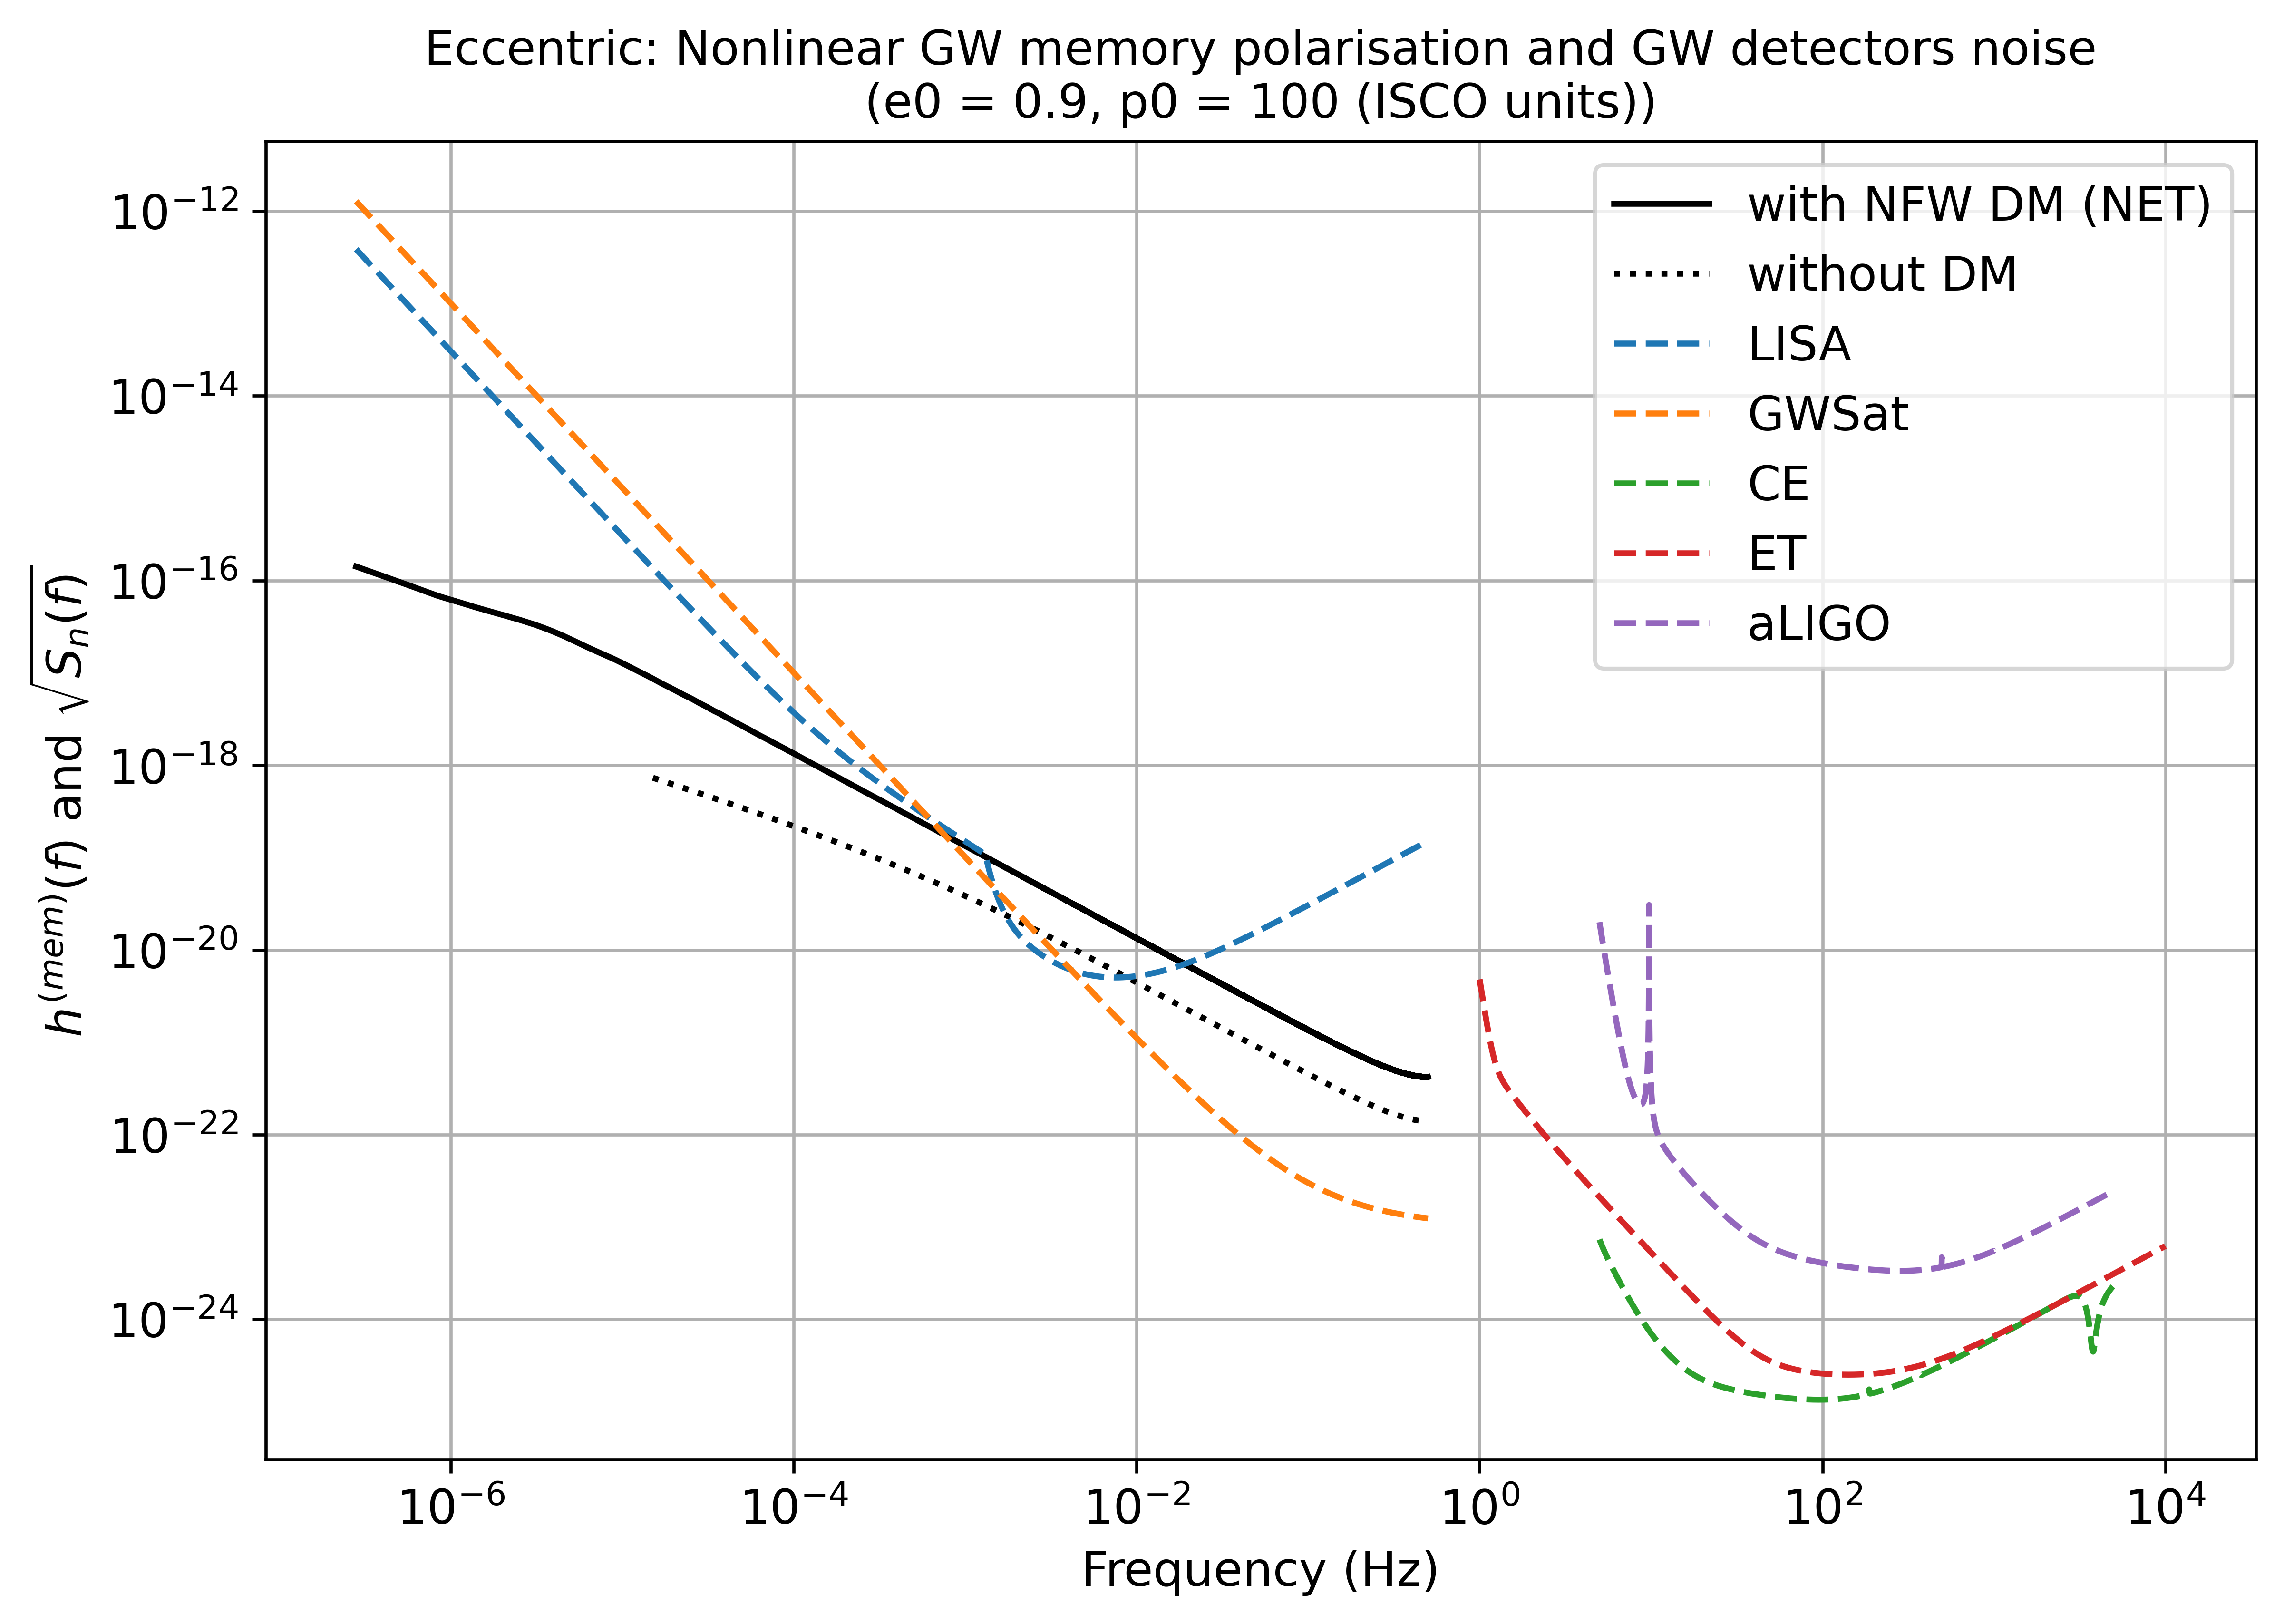

In [81]:
# Nonlinear memory GW polarisation frequency signal without DM (Only GW backrxn)
hp_f_mem_without_DM, pos_freq_without_DM = nonlinear_memory_gw_pol_fft(h20_mem_gw, h40_mem_gw)

# Nonlinear memory GW polarisation frequency signal with DM (NET Effect)
hp_f_mem_with_DM_NET, pos_freq_with_DM_NET = nonlinear_memory_gw_pol_fft(h20_mem_NET, h40_mem_NET)

# GW detectors noise spectrum : Split into frequency and noise strain
CE_frequency = CE_data[:, 0] # Cosmic explorer
CE_strain = CE_data[:, 1]
ET_frequency = ET_data[:, 0] # Einstein telescope
ET_strain = ET_data[:, 1]
aLIGO_frequency = aLIGO_data[:, 0]  # Advanced LIGO
aLIGO_strain = aLIGO_data[:, 1]
LISA_frequency, LISA_strain = LISA_noise_psd(pos_freq_without_DM, pos_freq_with_DM_NET)  # LISA
GWSat_frequency, GWSat_strain = GWSat_noise_psd(pos_freq_without_DM, pos_freq_with_DM_NET)  # GWsat

# Plotting : Nonlinear memory GW polarisation frequency spectrum VS noise PSD of various GW detectors
plt.figure(figsize=(9,6))
plt.title('Eccentric: Nonlinear GW memory polarisation and GW detectors noise'+"\n"+f'(e0 = {e_i}, p0 = {p_i} (ISCO units))')
plt.plot(pos_freq_with_DM_NET, hp_f_mem_with_DM_NET, color='black',label='with NFW DM (NET)')
plt.plot(pos_freq_without_DM, hp_f_mem_without_DM, color='black', linestyle=':', label='without DM')
plt.plot(LISA_frequency, LISA_strain, linestyle='--', label='LISA')
plt.plot(GWSat_frequency, GWSat_strain, linestyle='--', label='GWSat')
plt.plot(CE_frequency, CE_strain, linestyle='--', label='CE')
plt.plot(ET_frequency, ET_strain, linestyle='--', label='ET')
plt.plot(aLIGO_frequency, aLIGO_strain, linestyle='--', label='aLIGO')
plt.xlabel('Frequency (Hz)')
plt.ylabel(r'$h^{(mem)}(f)$ and $\sqrt{S_n (f)}$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()